In [ ]:
# Import modules
!pip install transformers
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from sklearn.model_selection import train_test_split

In [4]:
# Create train and test sets
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/capstone_dataset.csv',
                 names=['Sentiment', 'ID', 'Time Stamp', 'Status', 'User', 'Text'],
                 encoding='ISO-8859-1')
X = df['Text'].values
Y = (df['Sentiment'].values == 4).astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=100000, test_size=25000, random_state=100)

In [8]:
# Tokenize
tokenizer = transformers.AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
def tokenize(tokenizer, data):
  input_ids = list()
  attention_masks = list()
  for text in data:
    processed_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_attention_mask=True)
    input_ids.append(processed_text['input_ids'])
    attention_masks.append(processed_text['attention_mask'])
  return np.array(input_ids).astype('int32'), np.array(attention_masks).astype('int32')

X_train_ids, X_train_masks = tokenize(tokenizer, X_train)
X_test_ids, X_test_masks = tokenize(tokenizer, X_test)

In [40]:
# Build model
x_ids = tf.keras.layers.Input(128, dtype='int32')
x_masks = tf.keras.layers.Input(128, dtype='int32')
y = transformers.TFAlbertModel.from_pretrained('albert-base-v2')([x_ids, x_masks])
y_a = y[1]
y_b = y[0]
y_b = tf.squeeze(y_b[:, -1:, :], axis=1)
y = tf.keras.layers.Concatenate()([y_a, y_b])
y = tf.keras.layers.Dense(32, activation='relu')(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(1, activation='sigmoid')(y)
model = tf.keras.models.Model(inputs=[x_ids, x_masks], outputs=y)
model.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(name='precision'),
                                                                                             tf.keras.metrics.Recall(name='recall'), 'accuracy'])
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_albert_model_5 (TFAlbertMode ((None, 128, 768), ( 11683584    input_43[0][0]                   
                                                                 input_44[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None, 1, 768)]     0           tf_albert_model_5[0][

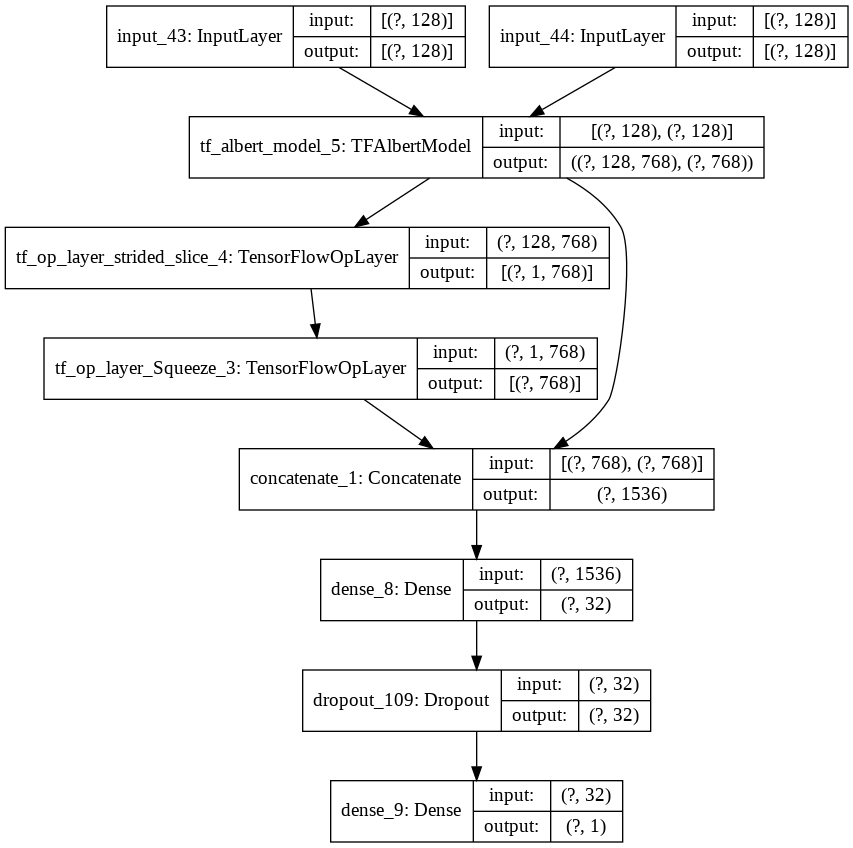

In [41]:
# Plot model
tf.keras.utils.plot_model(model, show_shapes=True)

In [43]:
# Model training and evaluation
model.fit([X_train_ids, X_train_masks], Y_train, batch_size=32)
print('Evaluating the model')
model.evaluate([X_test_ids, X_test_masks], Y_test)

3125/3125 [==============================] - 2402s 769ms/step - loss: 0.3796 - precision: 0.8314 - recall: 0.8254 - accuracy: 0.8298
Evaluating the model
782/782 [==============================] - 228s 292ms/step - loss: 0.3614 - precision: 0.8548 - recall: 0.8283 - accuracy: 0.8435


[0.3613514006137848,
 0.8548001646995544,
 0.8283159136772156,
 0.8435199856758118]

In [44]:
# Save model weights
model.save_weights('/content/drive/My Drive/Colab Notebooks/sentiment_analysis_lite_weights.h5')